In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


In [3]:
train = pd.read_csv('C:/Users/Hp/Documents/Minor project/train.csv')
test = pd.read_csv('C:/Users/Hp/Documents/Minor project/test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635.0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690.0,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174.0,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077.0,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270.0,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [5]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [7]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [8]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

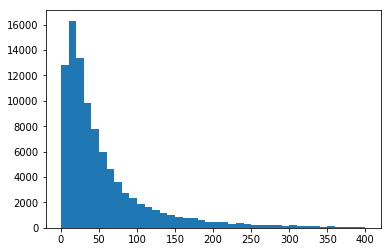

In [10]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [11]:
inp = Input(shape=(maxlen, ))

In [12]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [13]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [14]:
x = GlobalMaxPool1D()(x)

In [15]:
x = Dropout(0.1)(x)

In [16]:
x = Dense(50, activation="relu")(x)

In [17]:
x = Dropout(0.1)(x)

In [18]:
x = Dense(6, activation="sigmoid")(x)

In [19]:
from keras import backend as K
def f1_score(y, y_pred):
    def recall(y, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y, y_pred)
    recall = recall(y, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_score])
model.save('my_model.h5')

In [20]:
from keras import models 
model = models.load_model('my_model.h5', custom_objects= {'f1_score': f1_score})
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/2
86265/86265 [==============================] - 771s 9ms/step - loss: 0.0783 - acc: 0.9756 - f1_score: 0.4830 - val_loss: 0.0524 - val_acc: 0.9813 - val_f1_score: 0.6273
Epoch 2/2
86265/86265 [==============================] - 796s 9ms/step - loss: 0.0461 - acc: 0.9829 - f1_score: 0.6764 - val_loss: 0.0525 - val_acc: 0.9817 - val_f1_score: 0.6382


In [21]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape


(1, 200, 60)

In [22]:
a=model.predict(X_te)
print(a)

[[9.8989898e-01 2.4613339e-01 9.2119479e-01 8.4431916e-02 8.5674328e-01
  1.5793402e-01]
 [5.9191027e-04 8.6949217e-07 7.7865829e-05 5.6039385e-06 2.8411803e-05
  1.4541066e-05]
 [1.1548756e-03 2.0564855e-06 1.6922396e-04 1.5611224e-05 5.7787387e-05
  2.5911922e-05]
 ...
 [5.3097215e-04 5.3281946e-07 6.4951011e-05 2.1464318e-06 1.7196196e-05
  9.3910812e-06]
 [6.1846169e-04 8.6487250e-07 1.0821402e-04 3.1842656e-06 2.7683955e-05
  1.5160273e-05]
 [9.8481858e-01 7.7075459e-02 9.1500145e-01 1.3466483e-02 6.3344616e-01
  4.7949821e-02]]
